In [8]:
import os
from math import pi

os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # Use only the first GPU
from typing import Optional, Tuple, Callable, Union, List
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import vmap, jit
from jax import random
jax.config.update("jax_enable_x64", True)

import numpy as np
from astropy import units as u
from astropy import constants as c

import jdgsim
from jdgsim import construct_initial_state
from jdgsim.integrators import leapfrog
from jdgsim.dynamics import direct_acc, DIRECT_ACC
from jdgsim.option_classes import SimulationConfig, SimulationParams, NFWParams, PlummerParams, NFW_POTENTIAL
from jdgsim.initial_condition import Plummer_sphere, ic_two_body
from jdgsim.utils import center_of_mass
from jdgsim.time_integration import time_integration
from jdgsim.units import CodeUnits
from jdgsim.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot

import timeit


plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

# Plummer Sphere

In [2]:
code_length = 10.0 * u.kpc
code_mass = 1e8 * u.Msun
G = 1 
code_units = CodeUnits(code_length, code_mass, G=G)

In [3]:
# Define the 
config = SimulationConfig(N_particles=10_000, 
                          return_snapshots=True, 
                          num_snapshots=100, 
                          num_timesteps=1000, 
                          external_accelerations=(NFW_POTENTIAL,  ), 
                          acceleration_scheme=DIRECT_ACC,
                          softening=(0.1 * u.kpc).to(code_units.code_length).value) #default values

params = SimulationParams(t_end = (10 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                        a=(1 * u.kpc).to(code_units.code_length).value),
                          NFW_params = NFWParams(Mvir=(1e12 * u.Msun).to(code_units.code_mass).value,
                                                 r_s = (20 * u.kpc).to(code_units.code_length).value,
                                                 c = 10,),
                          G=G, ) 


In [ ]:
runtime_list = []
N_particles_list = [1, 5, 10, 50, 100, 500, 1_000, 5_000, 10_000, 50_000, 100_000]
for N_particles in N_particles_list:

    config = SimulationConfig(N_particles=N_particles, 
                          return_snapshots=True, 
                          num_snapshots=100, 
                          num_timesteps=1000, 
                          external_accelerations=(NFW_POTENTIAL,  ), 
                          acceleration_scheme=DIRECT_ACC,
                          softening=(0.1 * u.kpc).to(code_units.code_length).value) #default values

    params = SimulationParams(t_end = (10 * u.Gyr).to(code_units.code_time).value,  
                            Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                            a=(1 * u.kpc).to(code_units.code_length).value),
                            NFW_params = NFWParams(Mvir=(1e12 * u.Msun).to(code_units.code_mass).value,
                                                    r_s = (20 * u.kpc).to(code_units.code_length).value,
                                                    c = 10,),
                            G=G, ) 
    
    #set up the particles in the initial state
    positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(4), params=params, config=config)
    #put the Plummer sphere in a ciruclar orbit around the NFW halo
    rp=100*u.kpc.to(code_units.code_length)

    mass_inside_rp = 4*jnp.pi*params.NFW_params.d_c*params.NFW_params.r_s**3*(jnp.log(1+rp/params.NFW_params.r_s)-rp/(rp+params.NFW_params.r_s))

    if len(config.external_accelerations)>0:
        pos, vel, _ = ic_two_body(mass_inside_rp, params.Plummer_params.Mtot, rp=rp, e=0., config=config, params=params)
        velocities = velocities + vel[1]
        positions = positions + pos[1]

    #initialize the initial state
    initial_state = construct_initial_state(positions, velocities)
    
    snapshots = time_integration(initial_state, mass, config, params)
    runtime_list.append(snapshots.runtime)


/export/home/vgiusepp/miniconda3/envs/test_sstrax/lib/python3.12/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/export/home/vgiusepp/miniconda3/envs/test_sstrax/lib/python3.12/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/export/home/vgiusepp/miniconda3/envs/test_sstrax/lib/python3.12/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/export/home/vgiusepp/miniconda3/envs/test_sstrax/lib/python3.12/site-packages/jax/_src/core.py:700: FutureWarning: unhashable typ

Text(0, 0.5, 'Runtime [s]')

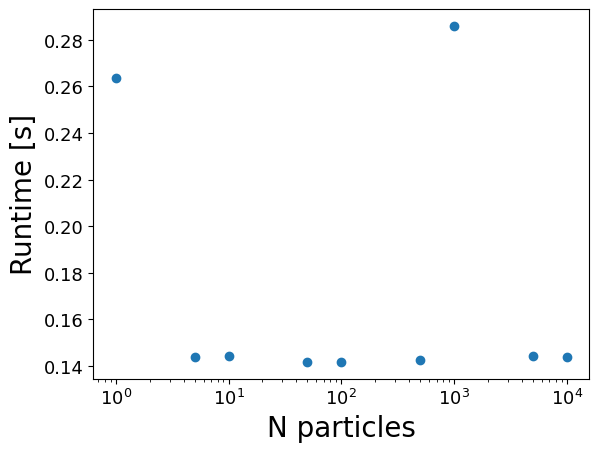

In [ ]:
plt.scatter(N_particles_list, runtime_list)
plt.xscale('log')
plt.xlabel('N particles')
plt.ylabel('Runtime [s]')


In [5]:


config = SimulationConfig(N_particles=10_000, 
                        return_snapshots=True, 
                        num_snapshots=100, 
                        num_timesteps=1000, 
                        external_accelerations=(NFW_POTENTIAL,  ), 
                        acceleration_scheme=DIRECT_ACC,
                        softening=(0.1 * u.kpc).to(code_units.code_length).value) #default values

params = SimulationParams(t_end = (10 * u.Gyr).to(code_units.code_time).value,  
                        Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                        a=(1 * u.kpc).to(code_units.code_length).value),
                        NFW_params = NFWParams(Mvir=(1e12 * u.Msun).to(code_units.code_mass).value,
                                                r_s = (20 * u.kpc).to(code_units.code_length).value,
                                                c = 10,),
                        G=G, ) 

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(4), params=params, config=config)
#put the Plummer sphere in a ciruclar orbit around the NFW halo
rp=100*u.kpc.to(code_units.code_length)

mass_inside_rp = 4*jnp.pi*params.NFW_params.d_c*params.NFW_params.r_s**3*(jnp.log(1+rp/params.NFW_params.r_s)-rp/(rp+params.NFW_params.r_s))

if len(config.external_accelerations)>0:
    pos, vel, _ = ic_two_body(mass_inside_rp, params.Plummer_params.Mtot, rp=rp, e=0., config=config, params=params)
    velocities = velocities + vel[1]
    positions = positions + pos[1]

#initialize the initial state
initial_state = construct_initial_state(positions, velocities)

# run for compilation
snapshots = jax.block_until_ready(time_integration(initial_state, mass, config, params))


/export/home/vgiusepp/miniconda3/envs/test_sstrax/lib/python3.12/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/export/home/vgiusepp/miniconda3/envs/test_sstrax/lib/python3.12/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


In [6]:
%timeit snapshots = jax.block_until_ready(time_integration(initial_state, mass, config, params))

11.8 s ± 30.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
runtime_list = []
N_particles_list = [10, 50, 100, 500, 1_000, 5_000, 10_000, 50_000]
for N_particles in N_particles_list:

    config = SimulationConfig(N_particles=N_particles, 
                          return_snapshots=True, 
                          num_snapshots=100, 
                          num_timesteps=1000, 
                          external_accelerations=(NFW_POTENTIAL,  ), 
                          acceleration_scheme=DIRECT_ACC,
                          softening=(0.1 * u.kpc).to(code_units.code_length).value) #default values

    params = SimulationParams(t_end = (10 * u.Gyr).to(code_units.code_time).value,  
                            Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                            a=(1 * u.kpc).to(code_units.code_length).value),
                            NFW_params = NFWParams(Mvir=(1e12 * u.Msun).to(code_units.code_mass).value,
                                                    r_s = (20 * u.kpc).to(code_units.code_length).value,
                                                    c = 10,),
                            G=G, ) 
    
    #set up the particles in the initial state
    positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(4), params=params, config=config)
    #put the Plummer sphere in a ciruclar orbit around the NFW halo
    rp=100*u.kpc.to(code_units.code_length)

    mass_inside_rp = 4*jnp.pi*params.NFW_params.d_c*params.NFW_params.r_s**3*(jnp.log(1+rp/params.NFW_params.r_s)-rp/(rp+params.NFW_params.r_s))

    if len(config.external_accelerations)>0:
        pos, vel, _ = ic_two_body(mass_inside_rp, params.Plummer_params.Mtot, rp=rp, e=0., config=config, params=params)
        velocities = velocities + vel[1]
        positions = positions + pos[1]

    #initialize the initial state
    initial_state = construct_initial_state(positions, velocities)
    
    snapshots = jax.block_until_ready( time_integration(initial_state, mass, config, params) )
    # Where you're currently using timeit.timeit()
    times = timeit.repeat(
        lambda: jax.block_until_ready(time_integration(initial_state, mass, config, params)),
        repeat=3,  # Number of times to repeat the measurement
        number=2   # Number of calls per measurement
    )

    mean_runtime = np.mean(times)
    std_runtime = np.std(times)
    runtime_list.append((mean_runtime, std_runtime))

Text(0.5, 1.0, 'Runtime scaling')

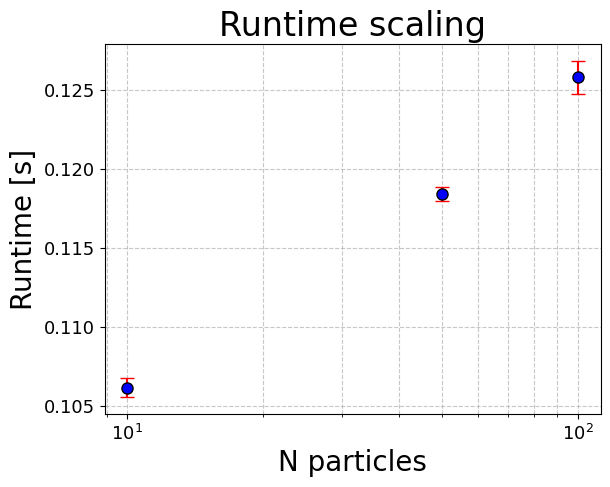

In [29]:
runtime_list = runtime_list[:-3]
N_particles_list = N_particles_list[:-3]

# Extract mean and std from runtime_list tuples
mean_times = [t[0] for t in runtime_list]
std_times = [t[1] for t in runtime_list]

# Create an error bar plot
plt.errorbar(N_particles_list, mean_times, yerr=std_times, fmt='o', capsize=5, 
             markersize=8, ecolor='red', markeredgecolor='black', markerfacecolor='blue')

# Set scales and labels
plt.xscale('log')
# plt.yscale('log')  # Optional - if you want log scale on the y-axis too
plt.xlabel('N particles')
plt.ylabel('Runtime [s]')
plt.grid(True, which="both", ls="--", alpha=0.7)

# Add a title
plt.title('Runtime scaling')
# plt.savefig('runtime_scaling.pdf')